## Anomaly Detection in Financial Transactions using Autoencoders + OPTICS(Clustering)

The goal of this project is to detect fraudulent credit card transactions using advanced anomaly detection techniques. Fraud detection is a critical problem in the financial industry due to the increasing number of online transactions and the significant losses associated with fraud. Traditional supervised machine learning approaches often face challenges because fraudulent cases are extremely rare compared to normal transactions, leading to highly imbalanced datasets.

In this project, we explore unsupervised learning methods — specifically Autoencoders and DBSCAN — to identify anomalies in credit card transactions. Autoencoders learn to reconstruct normal transaction patterns, and transactions with high reconstruction error are flagged as potential fraud. DBSCAN, a density-based clustering algorithm, is then applied on reconstruction errors to detect outliers that may represent fraudulent activities.

The dataset used is the Credit Card Fraud Detection dataset from Kaggle
, which contains 284,807 transactions with 31 features (including anonymized principal components, transaction time, amount, and a binary fraud label). Among these, only 492 transactions are fraudulent, representing just 0.172% of the dataset. This severe imbalance makes anomaly detection techniques particularly suitable for this problem.

In [38]:
# Import required libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler
import random, os
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


## Step1 : Data Loading & Preprocessing

In [39]:
# import dataset
df=pd.read_csv("creditcard.csv")
df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [40]:
df.shape

(284807, 31)

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [42]:
# Checking null values
df.isnull().sum()

,0
Time,0
V1,0
V2,0
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,0


In [43]:
# Checking class imbalance
print(df['Class'].value_counts(normalize=True))

Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


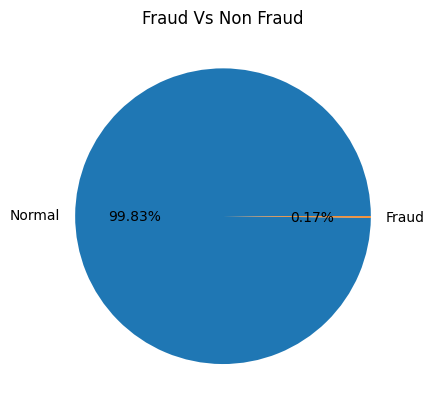

In [44]:
plt.pie(df['Class'].value_counts(normalize=True), labels=['Normal', 'Fraud'], autopct='%1.2f%%')
plt.title("Fraud Vs Non Fraud")
plt.show()

In [45]:
# Drop Time and Class for training
X = df.drop(['Time','Class'], axis=1)
y = df['Class']

###  Split the Data (Train only on non-fraud since we are using an AutoEncoder model)

In [46]:
from torch.utils.data import random_split

# Separate normal (nonfraud) and fraud
X_normal = X[df["Class"] == 0]
X_fraud  = X[df["Class"] == 1]

# Standardize the entire nonfraud dataset first
scaler = StandardScaler()
X_normal_scaled = scaler.fit_transform(X_normal.values)

# Convert to tensor
X_tensor = torch.tensor(X_normal_scaled, dtype=torch.float32)

# Split dataset (70/15/15)
total_size = len(X_tensor)
train_size = int(0.7 * total_size)
val_size   = int(0.15 * total_size)
test_size  = total_size - train_size - val_size

generator = torch.Generator().manual_seed(42)
X_train, X_val, X_test = random_split(
    X_tensor, [train_size, val_size, test_size], generator=generator
)

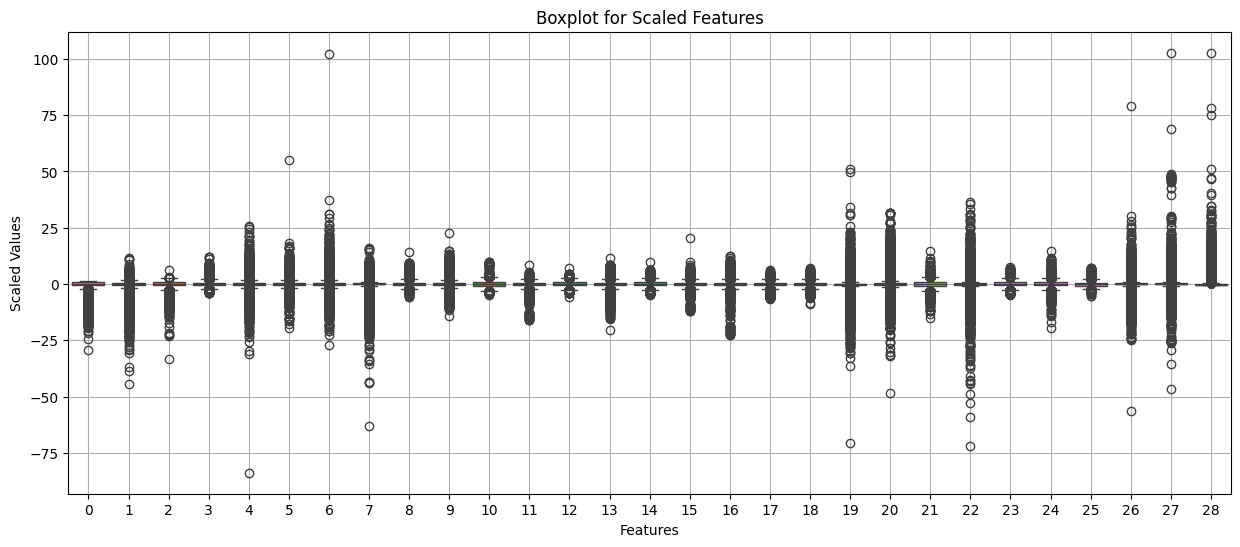

In [47]:
#checking for outliers in the data
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15, 6))
sns.boxplot(X_normal_scaled)
plt.title("Boxplot for Scaled Features")
plt.xlabel("Features")
plt.ylabel("Scaled Values")
plt.grid(True)
plt.show()

Interpretation:
Most features are centered around zero, with several showing extreme outliers typical of fraud patterns.

In [48]:
# Capping Outliers

# Helper: convert Subset -> numpy array
def subset_to_numpy(subset):
    return subset.dataset[subset.indices].numpy()

# Convert subsets back to numpy for capping
X_train_np = subset_to_numpy(X_train)
X_val_np   = subset_to_numpy(X_val)
X_test_np  = subset_to_numpy(X_test)

# Outlier capping function
def cap_outliers(X, lower_percentile=1, upper_percentile=99):
    X_capped = X.copy()
    lower_bounds = np.percentile(X, lower_percentile, axis=0)
    upper_bounds = np.percentile(X, upper_percentile, axis=0)
    for i in range(X.shape[1]):
        X_capped[:, i] = np.clip(X[:, i], lower_bounds[i], upper_bounds[i])
    return X_capped

# Apply capping
X_train_capped = cap_outliers(X_train_np, 1, 99)
X_val_capped   = cap_outliers(X_val_np, 1, 99)
X_test_capped  = cap_outliers(X_test_np, 1, 99)

# Convert back to tensors
X_train_tensor = torch.tensor(X_train_capped, dtype=torch.float32)
X_val_tensor   = torch.tensor(X_val_capped, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test_capped, dtype=torch.float32)


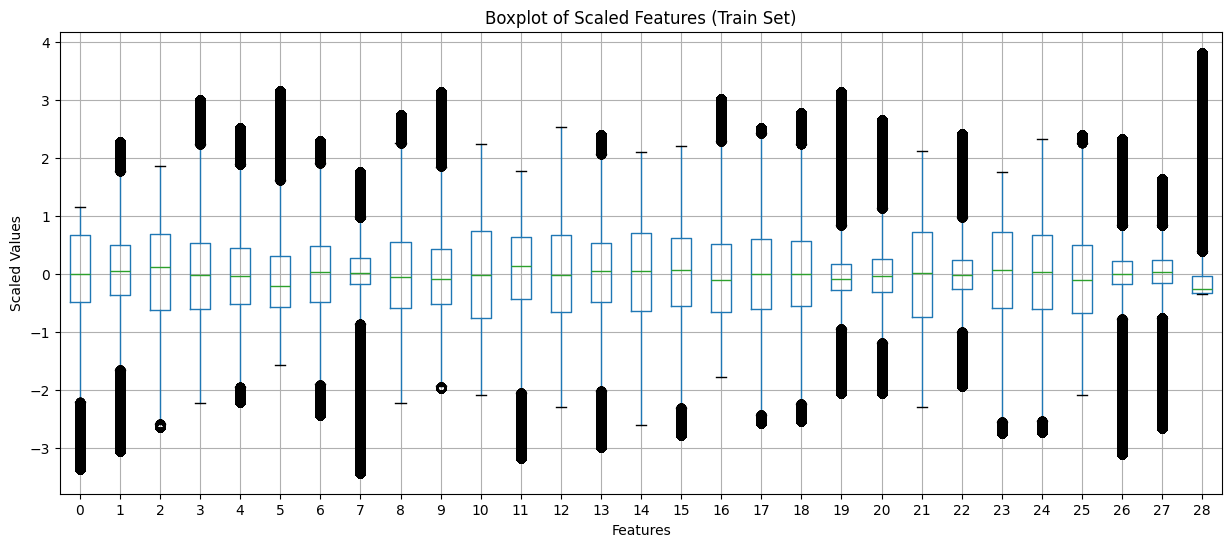

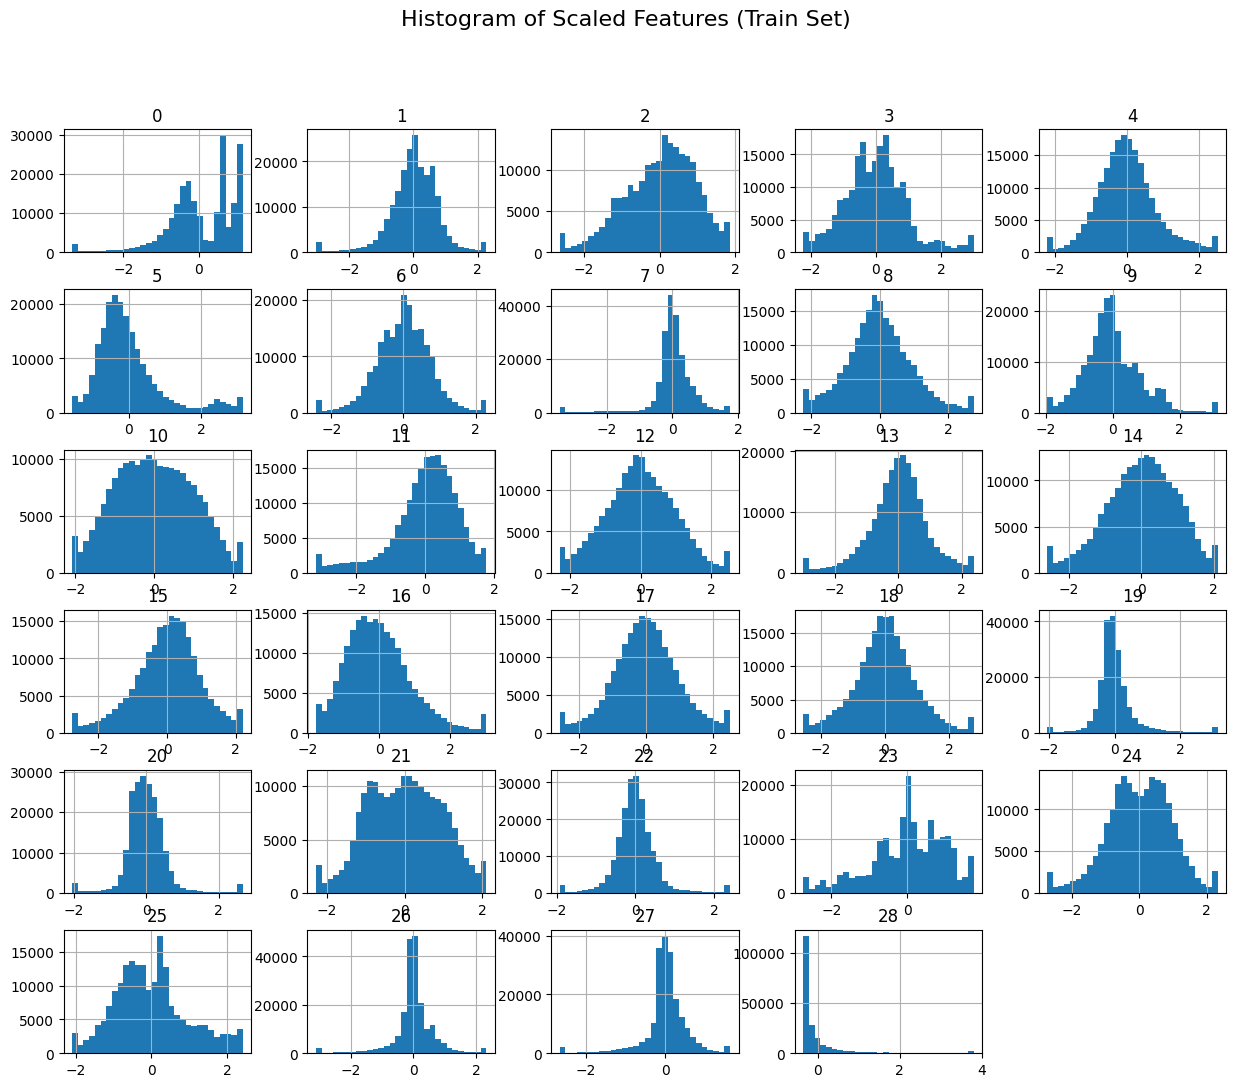

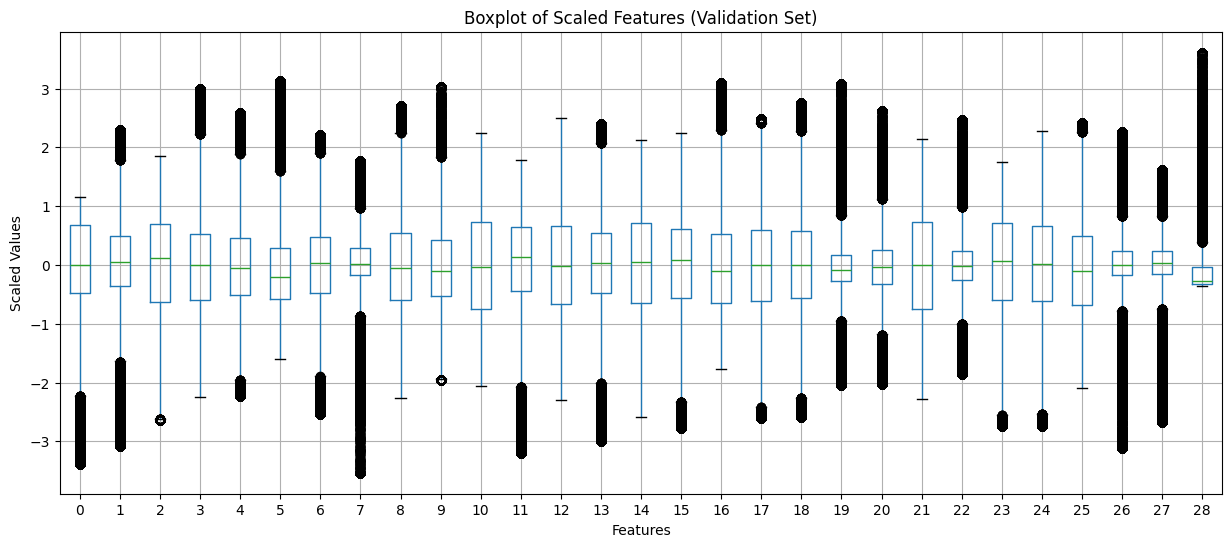

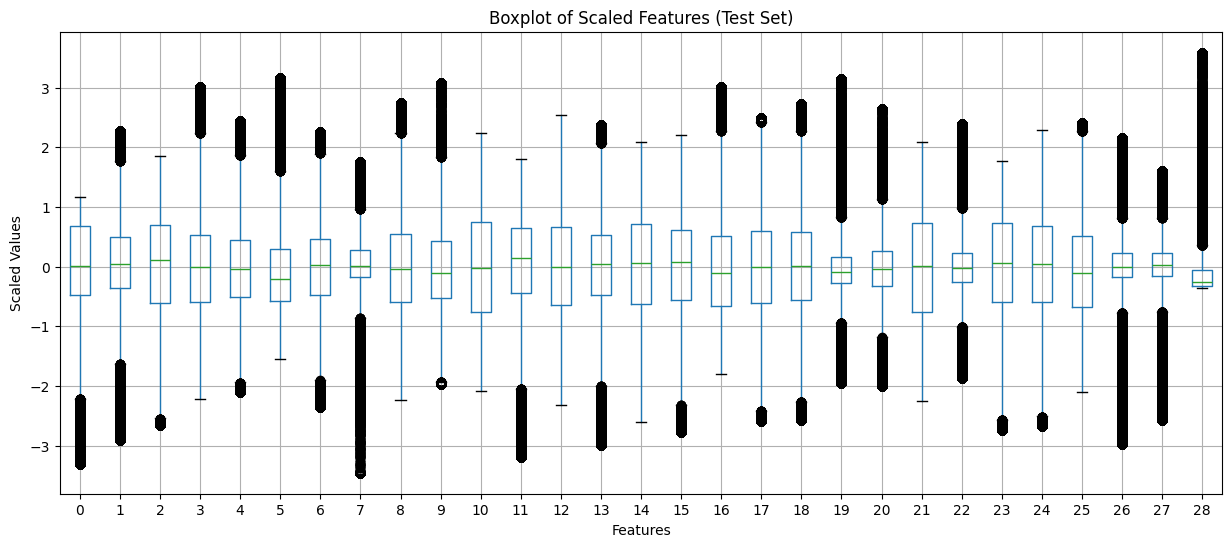

In [49]:
# Plot Boxplots after capping

# Convert tensors back to DataFrames for easier plotting
X_train_df = pd.DataFrame(X_train_tensor.numpy())
X_val_df = pd.DataFrame(X_val_tensor.numpy())
X_test_df = pd.DataFrame(X_test_tensor.numpy())

# Function to plot boxplots for each feature
def plot_boxplots(df, title):
    plt.figure(figsize=(15, 6))
    df.boxplot()
    plt.title(title)
    plt.xlabel("Features")
    plt.ylabel("Scaled Values")
    plt.show()

# Function to plot histograms for each feature
def plot_histograms(df, title):
    df.hist(figsize=(15, 12), bins=30)
    plt.suptitle(title, fontsize=16)
    plt.show()

# Plot for train set
plot_boxplots(X_train_df, "Boxplot of Scaled Features (Train Set)")
plot_histograms(X_train_df, "Histogram of Scaled Features (Train Set)")

# repeat for val and test sets if needed
plot_boxplots(X_val_df, "Boxplot of Scaled Features (Validation Set)")
plot_boxplots(X_test_df, "Boxplot of Scaled Features (Test Set)")


Interpretation:
After capping, the extreme outliers are reduced, and the feature distributions are more compact, making the dataset cleaner and more stable for model training.

In [50]:
# Create dataloaders

from torch.utils.data import TensorDataset, DataLoader
batch_size = 1024
train_dataloader = DataLoader(X_train_tensor, batch_size=batch_size, shuffle=True,generator=generator)
val_dataloader   = DataLoader(X_val_tensor, batch_size=batch_size, shuffle=False,generator=generator)
test_dataloader  = DataLoader(X_test_tensor, batch_size=batch_size, shuffle=False,generator=generator)


## Step 2 : Train Autoencoder model
Train a deep autoencoder on normal transactions to learn compact representations. Fraudulent transactions are expected to have higher reconstruction errors, which makes the model effective for anomaly detection.

In [51]:
# Autoencoder Architecture:
# - The encoder compresses the input data into a 32-dimensional latent representation.
# - The decoder reconstructs the input from this compressed form.
# - ReLU activations are used in hidden layers for non-linearity.
# - This structure helps capture key patterns and anomalies in transaction data
#   for fraud detection.

import torch.nn as nn
class Autoencoder(nn.Module):
    def __init__(self,input_dim):
        super(Autoencoder ,self).__init__()

        # Encoder
        self.encoder=nn.Sequential( nn.Linear(input_dim, 128),
                                    nn.ReLU(),
                                    nn.Linear(128, 64),
                                    nn.ReLU(),
                                    nn.Linear(64, 32))
        # Decoder
        self.decoder=nn.Sequential(nn.Linear(32, 64),
                                    nn.ReLU(),
                                    nn.Linear(64, 128),
                                    nn.ReLU(),
                                    nn.Linear(128, input_dim))
    #forward method
    def forward(self,x):
      encoded=self.encoder(x)
      decoded=self.decoder(encoded)
      return decoded


In [52]:
# Autoencoder Training Loop:
# - Uses Adam optimizer with weight decay to prevent overfitting.
# - Mean Squared Error (MSE) is the loss function, comparing input and reconstruction.
# - Gradient clipping (max_norm=1) is applied to stabilize training.
# - A learning rate scheduler (ReduceLROnPlateau) reduces LR when validation loss plateaus.
# - Early stopping with patience=5 prevents overfitting and saves the best model weights.
# - Tracks and stores training/validation losses for later visualization.


import torch.optim as optim

patience = 5  # Number of epochs to wait for improvement
best_val_loss = float('inf')  # Initialize best loss to infinity
patience_counter = 0  # Counts how many epochs since last improvement

input_dim=X.shape[1] # input_dim= no of features in the input data
model=Autoencoder(input_dim) # create an instance of Autoenoder class
criterion = nn.MSELoss()  # Mean Squared Error Loss b/t input and reconstructed data
optimizer=optim.Adam(model.parameters() , lr=6e-4,weight_decay=1e-6)
n_epochs=100
# Initialize lists to store losses for plotting
total_train_loss_list = []
total_val_loss_list = []

for epoch in range(n_epochs):
  model.train()  # set to training mode
  total_train_loss = 0
  for batch in train_dataloader:
    inputs=batch[0]

    outputs=model(inputs)
    loss=criterion(outputs,inputs)
    optimizer.zero_grad()
    loss.backward()
    # 👉 Apply gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

    optimizer.step()
    total_train_loss+=loss.item()

  model.eval()
  total_val_loss=0
  with torch.no_grad():
    for batch in val_dataloader:
      inputs=batch[0]
      outputs=model(inputs)
      loss=criterion(outputs,inputs)
      total_val_loss+=loss.item()



  # Average loss
  avg_train_loss = total_train_loss / len(train_dataloader)
  avg_val_loss = total_val_loss / len(val_dataloader)

  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       mode='min',
                                                       factor=0.5,
                                                       patience=2)
  scheduler.step(avg_val_loss)

  # Save for plotting
  total_train_loss_list.append(avg_train_loss)
  total_val_loss_list.append(avg_val_loss)

  print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

  # EARLY STOPPING CHECK
  if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0  # reset counter if improvement
        # Optional: save best model
        torch.save(model.state_dict(), "best_autoencoder.pth")
  else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break


Epoch 1, Train Loss: 0.7195, Val Loss: 0.6931
Epoch 2, Train Loss: 0.5951, Val Loss: 0.5808
Epoch 3, Train Loss: 0.5662, Val Loss: 0.5111
Epoch 4, Train Loss: 0.4840, Val Loss: 0.4817
Epoch 5, Train Loss: 0.4456, Val Loss: 0.4126
Epoch 6, Train Loss: 0.4015, Val Loss: 0.3893
Epoch 7, Train Loss: 0.4110, Val Loss: 0.3625
Epoch 8, Train Loss: 0.4405, Val Loss: 0.3294
Epoch 9, Train Loss: 0.3495, Val Loss: 0.2979
Epoch 10, Train Loss: 0.3152, Val Loss: 0.2834
Epoch 11, Train Loss: 0.2581, Val Loss: 0.2585
Epoch 12, Train Loss: 0.2699, Val Loss: 0.2388
Epoch 13, Train Loss: 0.2572, Val Loss: 0.2215
Epoch 14, Train Loss: 0.2209, Val Loss: 0.2267
Epoch 15, Train Loss: 0.2044, Val Loss: 0.1958
Epoch 16, Train Loss: 0.2434, Val Loss: 0.1937
Epoch 17, Train Loss: 0.2179, Val Loss: 0.1892
Epoch 18, Train Loss: 0.1995, Val Loss: 0.1780
Epoch 19, Train Loss: 0.2065, Val Loss: 0.1701
Epoch 20, Train Loss: 0.2221, Val Loss: 0.1774
Epoch 21, Train Loss: 0.1630, Val Loss: 0.1490
Epoch 22, Train Loss: 

In [53]:
# Weight Initialization Function:
# - Applies Xavier/Glorot uniform initialization to all Linear layer weights.
# - Sets biases (if present) to 0.0.
# - This helps improve convergence by keeping the scale of gradients balanced.
#
# model.apply(init_weights) applies this initialization to every Linear layer
# in the Autoencoder model.

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.0)

model.apply(init_weights)


Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=29, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=29, bias=True)
  )
)

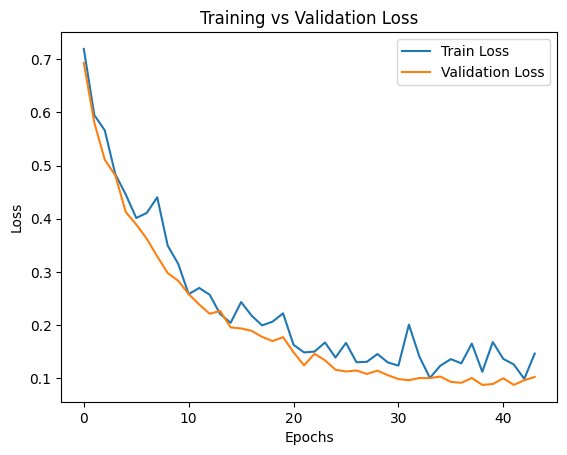

In [54]:
# Training loss vs Validation loss plot

plt.plot(total_train_loss_list, label='Train Loss')
plt.plot(total_val_loss_list, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()


## Step 3: Evaluate Autoencoder Reconstruction Errors




In [55]:
# Prepare the test set for evaluation:
# 1. Convert non-fraud test data back into a DataFrame after capping.
# 2. Scale the fraud samples using the same scaler for consistency.
# 3. Concatenate both non-fraud and fraud samples into a full test set.
# 4. Create corresponding labels (0 = non-fraud, 1 = fraud).
# 5. Convert the test set into a PyTorch tensor and pass it through the trained autoencoder.
# 6. Compute the reconstruction error for each sample (used later to detect anomalies/fraud).

X_test_non_fraud=pd.DataFrame(X_test_capped)
X_fraud = scaler.transform(X_fraud)
X_fraud=pd.DataFrame(X_fraud)

X_test_full = pd.concat([X_test_non_fraud, X_fraud], ignore_index=True)
y_test_full = np.concatenate([np.zeros(len(X_test_non_fraud)), np.ones(len(X_fraud))])

# Convert capped + scaled test set to torch tensor
X_test_tensor = torch.tensor(X_test_full.values, dtype=torch.float32)

with torch.no_grad():
    reconstructed = model(X_test_tensor)
    reconstruction_error = torch.mean((X_test_tensor - reconstructed) ** 2, dim=1)

errors = reconstruction_error.numpy()


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [56]:
error_df=pd.DataFrame({'Class':y_test_full,'Reconstruction_error':errors})
print(error_df.head(20))

    Class  Reconstruction_error
0     0.0              0.586116
1     0.0              0.409532
2     0.0              0.914586
3     0.0              0.655064
4     0.0              0.355822
5     0.0              0.370223
6     0.0              0.616434
7     0.0              0.318985
8     0.0              0.526548
9     0.0              0.771979
10    0.0              0.533545
11    0.0              0.316430
12    0.0              0.965083
13    0.0              0.212250
14    0.0              1.089152
15    0.0              0.631016
16    0.0              0.570943
17    0.0              0.860812
18    0.0              0.709109
19    0.0              0.683766


### Visualizing errors

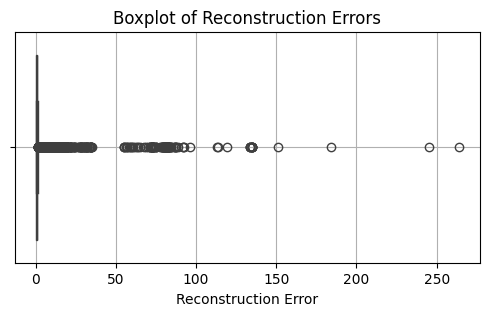

In [57]:
# Boxplot of  Reconstruction Errors
plt.figure(figsize=(6, 3))
sns.boxplot(x=errors)
plt.title("Boxplot of Reconstruction Errors")
plt.xlabel("Reconstruction Error")
plt.grid(True)
plt.show()

Interpretation:
The boxplot of reconstruction errors shows that most transactions have very low errors, while a few transactions exhibit extremely high errors. These high-error outliers are strong indicators of potential fraudulent transactions.

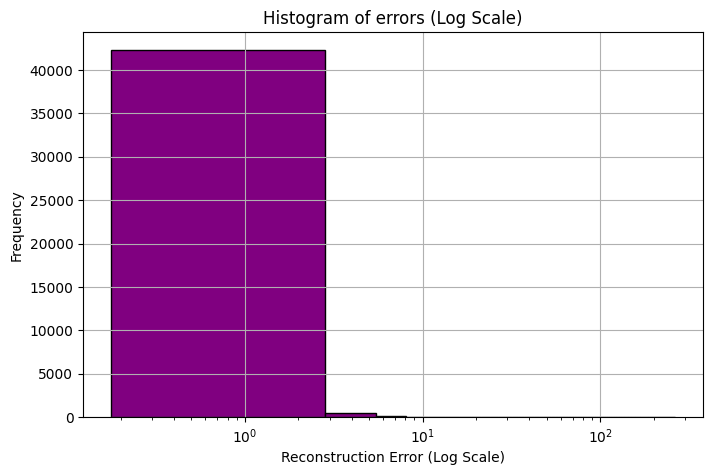

In [58]:
# Histogram of reconstruction errors
plt.figure(figsize=(8,5))
plt.hist(errors,bins=100,color='purple', edgecolor='black')
plt.xscale('log')
plt.title("Histogram of errors (Log Scale)")
plt.xlabel("Reconstruction Error (Log Scale)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

### Observation:
The above histogram confirms the reconstruction errors are tightly packed near zero, with a long tail of larger values — likely corresponding to anomalous or fraudulent transactions.

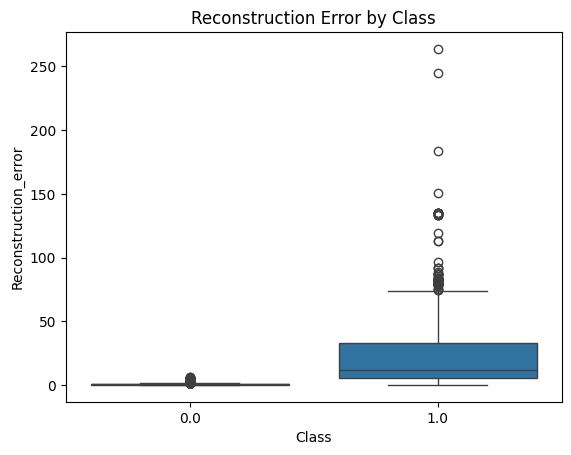

In [59]:
sns.boxplot(x='Class', y='Reconstruction_error', data=error_df)
plt.title("Reconstruction Error by Class")
plt.show()


Interpretation:
The boxplot shows that reconstruction errors for non-fraudulent transactions (Class 0) are very low and tightly clustered, while fraudulent transactions (Class 1) have much higher and more widely spread errors with many outliers. This indicates that the autoencoder effectively separates fraud from non-fraud based on reconstruction error.

## Step 4: Threshold Selection (PR Curve & ROC Curve)

In [60]:
# Set threshold as the 95th percentile of reconstruction errors from non-fraud (Class 0) data.
# Any transaction with error above this threshold will be flagged as potential fraud.
threshold=np.percentile(error_df[error_df["Class"]==0]["Reconstruction_error"],95)
print("Threshold:",threshold)

Threshold: 1.7129573


In [61]:
# # Predict fraud (1) or non-fraud (0) based on threshold.
# If reconstruction error ≥ threshold → classify as fraud, else non-fraud.
error_df["y_pred(threshold_95_perc)"]=error_df["Reconstruction_error"].apply(lambda x: 1 if x>=threshold else 0)
error_df.head()

,Class,Reconstruction_error,y_pred(threshold_95_perc)
0,0.0,0.586116,0
1,0.0,0.409532,0
2,0.0,0.914586,0
3,0.0,0.655064,0
4,0.0,0.355822,0


In [62]:
# Evaluate performance
from sklearn.metrics import classification_report , confusion_matrix
print(classification_report(error_df["Class"],error_df["y_pred(threshold_95_perc)"],digits=4))
print(confusion_matrix(error_df["Class"],error_df["y_pred(threshold_95_perc)"]))

              precision    recall  f1-score   support

         0.0     0.9987    0.9500    0.9737     42648
         1.0     0.1710    0.8943    0.2871       492

    accuracy                         0.9494     43140
   macro avg     0.5849    0.9221    0.6304     43140
weighted avg     0.9893    0.9494    0.9659     43140

[[40515  2133]
 [   52   440]]


Best Threshold: 2.9101915
ROC AUC: 0.9625785690538391


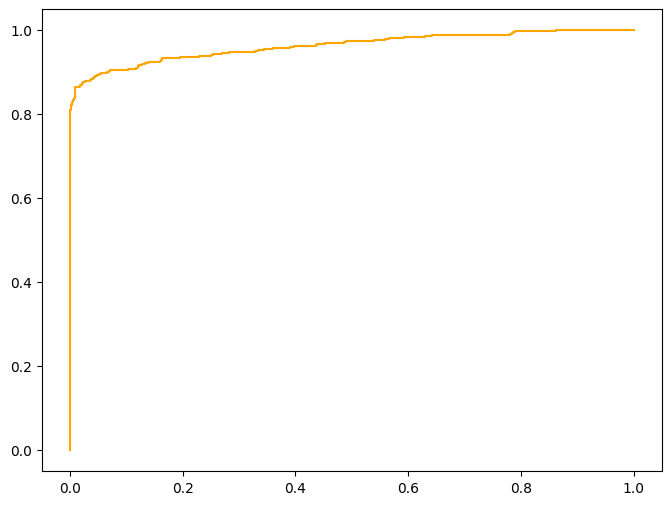

In [63]:
# Compute ROC curve and AUC using reconstruction errors
# Identify best threshold using Youden's J statistic (maximizing TPR - FPR)
# Plot ROC curve for model performance evaluation


from sklearn.metrics import roc_curve, auc
fpr,tpr,thesholds=roc_curve(error_df["Class"],error_df["Reconstruction_error"])
roc_auc=auc(fpr,tpr)
# Find best threshold (Youden's J statistic)
j_scores = tpr - fpr
j_best = np.argmax(j_scores)
best_threshold = thesholds[j_best]
print("Best Threshold:", best_threshold)
print("ROC AUC:", roc_auc)
# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr,tpr,color='orange',label='ROC')

In [64]:
# Find prediction based on the above threshold
error_df["y_pred(threshold_J_statistic)"]=error_df["Reconstruction_error"].apply(lambda x: 1 if x>=best_threshold else 0)
error_df.head()

,Class,Reconstruction_error,y_pred(threshold_95_perc),y_pred(threshold_J_statistic)
0,0.0,0.586116,0,0
1,0.0,0.409532,0,0
2,0.0,0.914586,0,0
3,0.0,0.655064,0,0
4,0.0,0.355822,0,0


In [65]:
# Evaluate metrics
from sklearn.metrics import classification_report , confusion_matrix
print(classification_report(error_df["Class"],error_df["y_pred(threshold_J_statistic)"],digits=4))
print(confusion_matrix(error_df["Class"],error_df["y_pred(threshold_J_statistic)"]))

              precision    recall  f1-score   support

         0.0     0.9984    0.9905    0.9945     42648
         1.0     0.5127    0.8638    0.6435       492

    accuracy                         0.9891     43140
   macro avg     0.7555    0.9272    0.8190     43140
weighted avg     0.9929    0.9891    0.9905     43140

[[42244   404]
 [   67   425]]


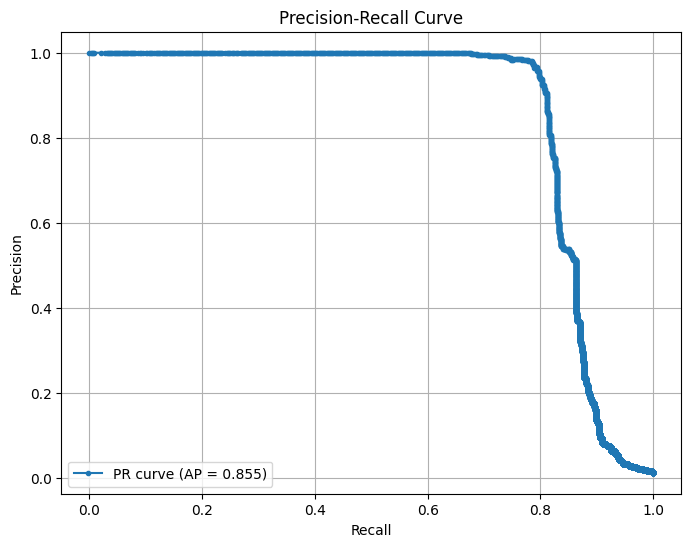

Best threshold by PR-F1: 4.9119
Precision: 0.9654, Recall: 0.7947, F1: 0.8718


In [66]:
# Compute Precision-Recall curve and Average Precision (AP)
# Plot PR curve to evaluate performance on imbalanced data (fraud detection)
# Find best threshold based on maximum F1-score (balance between precision & recall)


from sklearn.metrics import precision_recall_curve, average_precision_score

# ---- Step 1: Compute PR values ----
precision, recall, thresholds = precision_recall_curve(y_test_full, errors)
ap = average_precision_score(y_test_full, errors)

# ---- Step 2: Plot ----
plt.figure(figsize=(8,6))
plt.plot(recall, precision, marker='.', label=f'PR curve (AP = {ap:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

# ---- Step 3: Find best threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
best_idx = f1_scores.argmax()
best_threshold = thresholds[best_idx]

print(f"Best threshold by PR-F1: {best_threshold:.4f}")
print(f"Precision: {precision[best_idx]:.4f}, Recall: {recall[best_idx]:.4f}, F1: {f1_scores[best_idx]:.4f}")


In [67]:
# Find prediction with the threshold from PR Curve
error_df["y_pred(threshold_with_PRcurve)"]=error_df["Reconstruction_error"].apply(lambda x: 1 if x>=best_threshold else 0)
error_df.head()

,Class,Reconstruction_error,y_pred(threshold_95_perc),y_pred(threshold_J_statistic),y_pred(threshold_with_PRcurve)
0,0.0,0.586116,0,0,0
1,0.0,0.409532,0,0,0
2,0.0,0.914586,0,0,0
3,0.0,0.655064,0,0,0
4,0.0,0.355822,0,0,0


In [68]:
# Evaluate metrics
print(classification_report(error_df["Class"],error_df["y_pred(threshold_with_PRcurve)"],digits=4))
print(confusion_matrix(error_df["Class"],error_df["y_pred(threshold_with_PRcurve)"]))

              precision    recall  f1-score   support

         0.0     0.9976    0.9997    0.9987     42648
         1.0     0.9654    0.7947    0.8718       492

    accuracy                         0.9973     43140
   macro avg     0.9815    0.8972    0.9352     43140
weighted avg     0.9973    0.9973    0.9972     43140

[[42634    14]
 [  101   391]]


##  Step 5: Run Clustering (OPTICS) on Reconstruction Errors
 Apply OPTICS clustering on reconstruction errors.  
 The idea is that fraudulent transactions are rare and behave like anomalies,  
 so OPTICS labels (-1) are mapped to fraud, while cluster labels (≥0) are mapped to non-fraud.  


In [69]:
from sklearn.cluster import OPTICS

# Reshape errors into 2D for OPTICS
reshaped_errors=errors.reshape(-1,1)

# OPTICS clustering
optics=OPTICS(min_samples=5,xi=0.05,min_cluster_size=0.05)
optics_labels=optics.fit_predict(reshaped_errors)

# Map outliers (-1) to fraud, cluster labels >=0 to non-fraud
y_pred_optics = np.where(optics_labels == -1, 1, 0)


/usr/local/lib/python3.12/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


In [70]:
# Evaluate OPTICS clustering performance by comparing predicted labels (fraud vs. non-fraud)
# against the true class labels.
print(classification_report(error_df["Class"],y_pred_optics,digits=4))
print(confusion_matrix(error_df["Class"],y_pred_optics))

              precision    recall  f1-score   support

         0.0     0.9992    0.3451    0.5130     42648
         1.0     0.0169    0.9756    0.0332       492

    accuracy                         0.3523     43140
   macro avg     0.5080    0.6604    0.2731     43140
weighted avg     0.9880    0.3523    0.5076     43140

[[14719 27929]
 [   12   480]]


## Step 6 : Hybrid Decision Rule
 Combine Autoencoder predictions with OPTICS outlier flags.
 Rule: A transaction is fraud if flagged by the Autoencoder OR
 flagged by OPTICS with reconstruction error above a cutoff.
 This approach leverages Autoencoder’s precision and OPTICS’ ability
 to catch subtle anomalies, creating a more balanced detection system.


In [71]:
## Hybrid Threshold Tuning
# Test different percentile cutoffs on reconstruction errors to balance
# precision and recall in the hybrid model.
# For each cutoff, transactions flagged by Autoencoder OR
# (OPTICS + high reconstruction error) are marked as fraud.
# The classification report is generated for each cutoff to compare performance.


import numpy as np
from sklearn.metrics import classification_report, precision_recall_curve

# Get reconstruction errors and true labels
errors = error_df["Reconstruction_error"].values
y_true = error_df["Class"].values
y_pred_ae = error_df["y_pred(threshold_with_PRcurve)"].values  # AE-only predictions
y_pred_optics = y_pred_optics  # from your earlier OPTICS/DBSCAN step

# Candidate cutoffs (percentiles)
percentiles = [95, 97, 98, 99, 99.5]

results = {}

for p in percentiles:
    cutoff = np.percentile(errors, p)
    y_pred_hybrid = np.where((y_pred_ae==1) | ((y_pred_optics==1) & (errors > cutoff)), 1, 0)

    report = classification_report(y_true, y_pred_hybrid, output_dict=True, digits=4)
    results[p] = {
        "precision": report["1.0"]["precision"],
        "recall": report["1.0"]["recall"],
        "f1": report["1.0"]["f1-score"]
    }

# Print results
for p, metrics in results.items():
    print(f"Cutoff {p}th percentile -> Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}, F1: {metrics['f1']:.4f}")


Cutoff 95th percentile -> Precision: 0.2017, Recall: 0.8841, F1: 0.3284
Cutoff 97th percentile -> Precision: 0.3305, Recall: 0.8699, F1: 0.4790
Cutoff 98th percentile -> Precision: 0.4925, Recall: 0.8638, F1: 0.6273
Cutoff 99th percentile -> Precision: 0.9190, Recall: 0.8069, F1: 0.8593
Cutoff 99.5th percentile -> Precision: 0.9654, Recall: 0.7947, F1: 0.8718


In [72]:
# Now combine Autoencoder thresholding + OPTICS outlier flag.We can use an OR rule: predict fraud if either
# method flags it.

higher_cutoff=np.percentile(error_df["Reconstruction_error"],98)
y_pred_hybrid=np.where((error_df["y_pred(threshold_with_PRcurve)"]==1) | ((y_pred_optics==1) & (error_df["Reconstruction_error"]>higher_cutoff)),1,0)

In [73]:
# Evaluate metrics
print(classification_report(error_df["Class"],y_pred_hybrid,digits=4))
print(confusion_matrix(error_df["Class"],y_pred_hybrid))

              precision    recall  f1-score   support

         0.0     0.9984    0.9897    0.9941     42648
         1.0     0.4925    0.8638    0.6273       492

    accuracy                         0.9883     43140
   macro avg     0.7454    0.9268    0.8107     43140
weighted avg     0.9926    0.9883    0.9899     43140

[[42210   438]
 [   67   425]]



## Step 7 : Model Comparison



In [74]:
# Compare performance of individual methods (Autoencoder, OPTICS/DBSCAN)
# and the Hybrid approach using precision, recall, and F1-score.
# This helps evaluate whether combining models improves fraud detection.


from sklearn.metrics import classification_report
print("AutoEncoeder only:")
print(classification_report(y_test_full,error_df["y_pred(threshold_with_PRcurve)"],digits=4))
print("DBSCAN only:")
print(classification_report(y_test_full,y_pred_optics,digits=4))
print("Hybrid:")
print(classification_report(y_test_full,y_pred_hybrid,digits=4))


AutoEncoeder only:
              precision    recall  f1-score   support

         0.0     0.9976    0.9997    0.9987     42648
         1.0     0.9654    0.7947    0.8718       492

    accuracy                         0.9973     43140
   macro avg     0.9815    0.8972    0.9352     43140
weighted avg     0.9973    0.9973    0.9972     43140

DBSCAN only:
              precision    recall  f1-score   support

         0.0     0.9992    0.3451    0.5130     42648
         1.0     0.0169    0.9756    0.0332       492

    accuracy                         0.3523     43140
   macro avg     0.5080    0.6604    0.2731     43140
weighted avg     0.9880    0.3523    0.5076     43140

Hybrid:
              precision    recall  f1-score   support

         0.0     0.9984    0.9897    0.9941     42648
         1.0     0.4925    0.8638    0.6273       492

    accuracy                         0.9883     43140
   macro avg     0.7454    0.9268    0.8107     43140
weighted avg     0.9926    0.9883 

## Conclusion:
The primary goal of this project was to maximize the detection of fraudulent credit card transactions. While the Autoencoder model achieved strong precision with relatively high recall, and OPTICS clustering showed very high recall but poor precision, the hybrid model provided the best balance. By combining Autoencoder thresholding with OPTICS-based anomaly detection, the hybrid approach achieved the highest recall for fraud cases, ensuring that the majority of fraudulent transactions are captured.

Although this comes with some trade-off in precision, such a strategy is well-suited for fraud detection tasks, where missing fraudulent activity is far more costly than investigating additional false positives. Hence, the hybrid model stands out as the most effective solution among the tested approaches.